In [ ]:
import zipfile
from google.colab import drive
drive.mount('/content/drive/')
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/aider_data.zip",
'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Models
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D

import os

folder_path = '/tmp/AIDER'
for dirname, _, filenames in os.walk(folder_path):
    print(dirname)

/tmp/AIDER
/tmp/AIDER/flooded_areas
/tmp/AIDER/traffic_incident
/tmp/AIDER/collapsed_building
/tmp/AIDER/normal
/tmp/AIDER/fire


In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

In [ ]:
import matplotlib.image as mpimg
%matplotlib inline


train_datagen = ImageDataGenerator(
                fill_mode = 'nearest',
                validation_split=0.2
                )


train_generator=train_datagen.flow_from_directory(
    folder_path,
    target_size=(108,108),
    color_mode='rgb',
    class_mode='categorical',
    subset='training',
    )


validation_generator=train_datagen.flow_from_directory(
    folder_path,
    target_size=(108,108),
    color_mode='rgb',
    class_mode='categorical',
    subset='validation',
    )

Found 5147 images belonging to 5 classes.
Found 1286 images belonging to 5 classes.


In [ ]:
from keras.applications import ResNet101
model = tf.keras.models.Sequential([
    ResNet101(input_shape=(108,108,3), include_top=False),
    ])
for layer in model.layers:
    layer.trainable = False


model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))
model.summary()

171446536/171446536 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 4, 4, 2048)        42658176  
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 64)          1179712   
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 1, 64)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                

In [ ]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=25,
                    verbose=1,
                    )

Epoch 1/25
161/161 [==============================] - 34s 136ms/step - loss: 0.9482 - accuracy: 0.7367 - val_loss: 0.3659 - val_accuracy: 0.8810
Epoch 2/25
161/161 [==============================] - 17s 107ms/step - loss: 0.3712 - accuracy: 0.8768 - val_loss: 0.3803 - val_accuracy: 0.8764
Epoch 3/25
161/161 [==============================] - 19s 120ms/step - loss: 0.2634 - accuracy: 0.9157 - val_loss: 0.3545 - val_accuracy: 0.9020
Epoch 4/25
161/161 [==============================] - 18s 109ms/step - loss: 0.1475 - accuracy: 0.9516 - val_loss: 0.4983 - val_accuracy: 0.8888
Epoch 5/25
161/161 [==============================] - 17s 107ms/step - loss: 0.0942 - accuracy: 0.9726 - val_loss: 0.4032 - val_accuracy: 0.8904
Epoch 6/25
161/161 [==============================] - 19s 116ms/step - loss: 0.0636 - accuracy: 0.9798 - val_loss: 0.6969 - val_accuracy: 0.8639
Epoch 7/25
161/161 [==============================] - 18s 109ms/step - loss: 0.0952 - accuracy: 0.9701 - val_loss: 0.4718 - val_ac

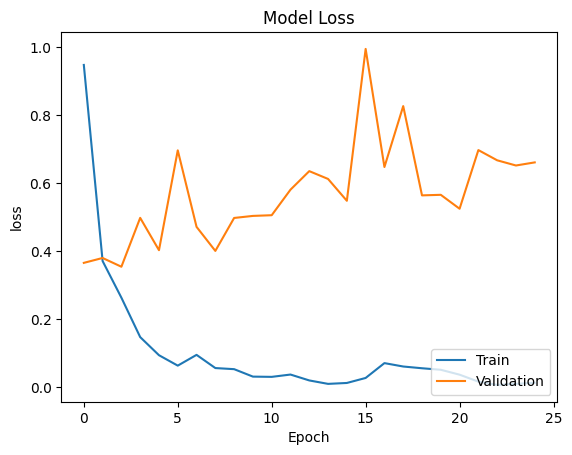

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

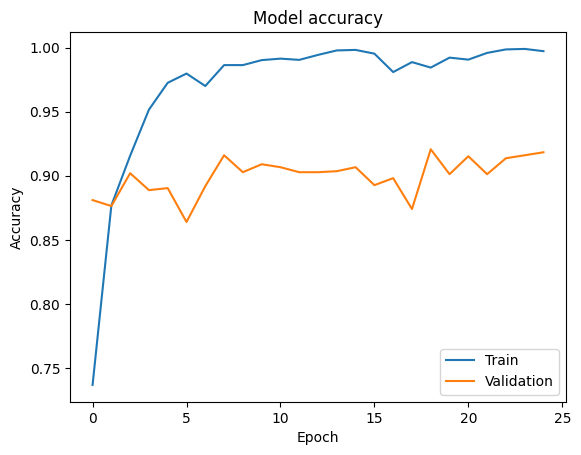

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
# Fine-tuning
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# Data Augmentation
train_datagen = ImageDataGenerator(
    fill_mode='nearest',
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    )

validation_datagen = ImageDataGenerator(
    fill_mode='nearest',
    validation_split=0.2,
    )

# Note: No need for a separate test data generator
# Train, Validation, and Test Generators
train_generator = train_datagen.flow_from_directory(
    folder_path,
    target_size=(108, 108),
    color_mode='rgb',
    class_mode='categorical',
    subset='training',
    )

validation_generator = validation_datagen.flow_from_directory(
    folder_path,
    target_size=(108, 108),
    color_mode='rgb',
    class_mode='categorical',
    subset='validation',
    )


# Note: No need for a separate test generator
# Use the entire dataset for testing
test_generator = validation_datagen.flow_from_directory(
    folder_path,
    target_size=(108, 108),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False, # Do not shuffle the test set
    )


# Build Model
model = Sequential([
      ResNet101(input_shape=(108, 108, 3), include_top=False),
])

# Freeze ResNet layers
for layer in model.layers:
      layer.trainable = False


# Add Custom Classification Head
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))
# Compile Model
optimizer = Adam(learning_rate=0.001)


model.compile(optimizer=optimizer, loss='categorical_crossentropy',
metrics=['accuracy'])

# Train Model
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=25,
                    verbose=1,
                    )


# Evaluate on the Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

# Predict classes for the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true classes from the generator
y_true = test_generator.classes
# Convert one-hot encoded class labels to integer labels
class_labels = list(test_generator.class_indices.keys())
y_true_labels = [class_labels[i] for i in y_true]
y_pred_labels = [class_labels[i] for i in y_pred_classes]
# Print the classification report
print(classification_report(y_true_labels, y_pred_labels))

Found 5147 images belonging to 5 classes.
Found 1286 images belonging to 5 classes.
Found 6433 images belonging to 5 classes.
171446536/171446536 [==============================] - 8s 0us/step
Epoch 1/25
161/161 [==============================] - 46s 217ms/step - loss: 1.1962 - accuracy: 0.6660 - val_loss: 0.4671 - val_accuracy: 0.8437
Epoch 2/25
161/161 [==============================] - 30s 186ms/step - loss: 0.7230 - accuracy: 0.7636 - val_loss: 0.5267 - val_accuracy: 0.8219
Epoch 3/25
161/161 [==============================] - 30s 187ms/step - loss: 0.6373 - accuracy: 0.7808 - val_loss: 0.4692 - val_accuracy: 0.8421
Epoch 4/25
161/161 [==============================] - 31s 194ms/step - loss: 0.5611 - accuracy: 0.8115 - val_loss: 0.3816 - val_accuracy: 0.8663
Epoch 5/25
161/161 [==============================] - 30s 186ms/step - loss: 0.5084 - accuracy: 0.8216 - val_loss: 0.3579 - val_accuracy: 0.8764
Epoch 6/25
161/161 [==============================] - 34s 211ms/step - loss: 0.452